In [12]:
# library
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import accuracy_score

In [16]:
# 사진으로부터 데이터 추출
x_loc = [27]
y_loc = [710, 733]
for i in range(19):
    x_loc.append(int(x_loc[0]+(25.5*(i+1))))
print(x_loc)
print(y_loc)

data = []
for i in range(12):
    tmp = Image.open(f'baduk/baduk{i+1}.jpg')
    black = tmp.convert('L')
    pix = np.array(black)
    for x in x_loc:
        for y in y_loc:
            data.append(pix[y][x])

print(len(data))

# 이상치 제거
outlier = list(filter(lambda x: 10 < data[x] < 200, range(len(data))))
outlier = sorted(outlier, reverse=True)
print(outlier)

for r in outlier:
    del data[r]
print(len(data))

# 이진분류 데이터로 전처리
for i in range(len(data)):
    if data[i] <= 10:
        data[i] = 0 # 흑색
    if data[i] >= 200:
        data[i] = 1 # 백색
data = np.array(data)
data = data.reshape(-1, 1)
data = data.astype('float32')
print(data.shape)

df = pd.DataFrame(data)
df.columns = ['data']
test = pd.DataFrame(data[-20:])
test.columns = ['data']
print(df)
print(test)

[27, 52, 78, 103, 129, 154, 180, 205, 231, 256, 282, 307, 333, 358, 384, 409, 435, 460, 486, 511]
[710, 733]
480
[479, 439, 359, 239, 159, 39]
474
(474, 1)
     data
0     0.0
1     1.0
2     1.0
3     1.0
4     0.0
..    ...
469   0.0
470   1.0
471   0.0
472   0.0
473   1.0

[474 rows x 1 columns]
    data
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    1.0
6    1.0
7    0.0
8    1.0
9    0.0
10   1.0
11   0.0
12   0.0
13   1.0
14   1.0
15   0.0
16   1.0
17   0.0
18   0.0
19   1.0


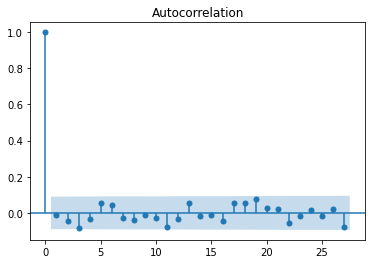

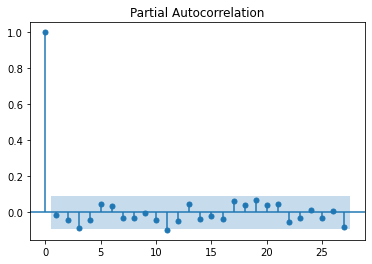

In [17]:
# ACF, PACF plot
plot_acf(df)
plot_pacf(df)
plt.show()

In [18]:
# 차분
y = df['data']
y_1diff = df.diff().dropna()['data']
result = adfuller(y)
print(f'원 데이터 ADF Statistic : {result[0] : .4f}')
print(f'원 데이터 p-value : {result[1] : .4f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic : {result[0] : .4f}')
print(f'1차 차분 p-value : {result[1] : .4f}')

원 데이터 ADF Statistic : -21.9554
원 데이터 p-value :  0.0000
1차 차분 ADF Statistic : -10.0279
1차 차분 p-value :  0.0000


In [19]:
# arima model
model = ARIMA(df, order=(0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                   data   No. Observations:                  474
Model:                     ARMA(0, 0)   Log Likelihood                -343.755
Method:                           css   S.D. of innovations              0.500
Date:                Tue, 22 Sep 2020   AIC                            691.510
Time:                        13:47:03   BIC                            699.832
Sample:                             0   HQIC                           694.783
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4831      0.023     21.049      0.000       0.438       0.528


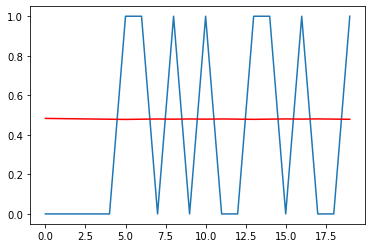

In [21]:
# rolling forecast
history = [x for x in df['data']]
predictions = []
for i in range(len(test)):
    model = ARIMA(history, order=(0,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    tmp = test['data'][i]
    history.append(tmp)
    
plt.plot(test.index, test['data'])
plt.plot(test.index, predictions, color='red')
plt.show()

In [22]:
def auto_arima(data, order, sort='AIC'):
    order_lst = []
    aic_lst = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    order_lst.append(c_order)
                    aic_lst.append(aic)
                except:
                    pass
    result_auto = pd.DataFrame(list(zip(order_lst, aic_lst)), columns=['order', 'AIC'])
    result_auto.sort_values(sort, inplace=True)
    return result_auto

result = auto_arima(df, [3,3,3])
result

,order,AIC
0,p0 d0 q0,691.509810
10,p1 d0 q1,692.797646
1,p0 d0 q1,693.438370
9,p1 d0 q0,693.444741
2,p0 d0 q2,694.355908
15,p2 d0 q0,694.543963
4,p0 d1 q1,697.238142
18,p2 d1 q2,698.709104
5,p0 d1 q2,699.130057
12,p1 d1 q1,699.140440


In [29]:
model = ARIMA(df, order=(0,0,1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                   data   No. Observations:                  474
Model:                     ARMA(0, 1)   Log Likelihood                -343.719
Method:                       css-mle   S.D. of innovations              0.500
Date:                Tue, 22 Sep 2020   AIC                            693.438
Time:                        13:49:31   BIC                            705.922
Sample:                             0   HQIC                           698.348
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4831      0.023     21.325      0.000       0.439       0.528
ma.L1.data    -0.0129      0.048     -0.267      0.789      -0.108       0.082
                                    Roots           

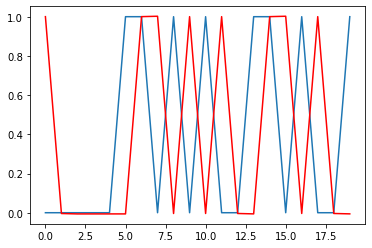

In [37]:
# rolling forecast
history = [x for x in df['data']]
predictions = []
for i in range(len(test)):
    model = ARIMA(history, order=(0,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    tmp = test['data'][i]
    history.append(tmp)
    
plt.plot(test.index, test['data'])
plt.plot(test.index, predictions, color='red')
plt.show()